# Boston House Prices

In [276]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

In [277]:
train = pd.read_csv('./train.csv')      #1460*81
test = pd.read_csv('./test.csv')        #1459*80

train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

train.shape, test.shape

((1460, 80), (1459, 79))

In [278]:
y = train['SalePrice']

y = np.log(y, where=y != 0)

train = train.drop('SalePrice', axis=1)

In [279]:
all_features = pd.concat([train, test], ignore_index=True)

In [280]:
# 범주형 데이터 추출
categorical_features = all_features.select_dtypes(include=['object'])
categorical_features = pd.get_dummies(categorical_features, dummy_na=True)
print(categorical_features.shape)

(2919, 295)


In [281]:
# 수치형 데이터 추출
numeric_features = all_features.select_dtypes(exclude=['object'])
numeric_features = numeric_features.apply(lambda x: (x - x.mean()) / (x.std()))
numeric_features = numeric_features.fillna(0)
numeric_features.shape

(2919, 36)

In [282]:
all_features = np.concatenate([categorical_features,numeric_features],1)
X = all_features[:len(y), :]
X_test = all_features[len(y):, :]
X.shape, y.shape, X_test.shape

((1460, 331), (1460,), (1459, 331))

모델

In [283]:
class Model(nn.Module):
    def __init__(self, D_in=331, H=222, D_out=1, Hn=4):
        super().__init__()
        self.Hn = Hn 
        self.activation = nn.Softplus() 
        
        self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation]) 
        for i in range(self.Hn - 1):
            self.layers.extend([nn.Linear(H, H), self.activation]) 
        self.layers.append(nn.Linear(H, D_out)) 
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [284]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [285]:
type(y)

pandas.core.series.Series

In [286]:
from sklearn.model_selection import train_test_split
y=y.to_numpy()
X_train , X_val , y_train , y_val = train_test_split(X, y,test_size=0.2, shuffle=True,random_state=5252)

y_val = torch.tensor(y_val).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_val = torch.tensor(X_val).float().to(device)

y_train = torch.tensor(y_train).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(X_train).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

X_test= torch.tensor(X_test).float().to(device)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)


torch.Size([1168, 331]) torch.Size([1168, 1])
torch.Size([292, 331]) torch.Size([292, 1])
torch.Size([1459, 331])


In [291]:
model = Model()
model.to(device)

model = Model().to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.MSELoss() 

In [292]:
train_losses = [] 
val_losses = [] 
epochs = 300

X_val , y_val = X_val.to(device) , y_val.to(device)

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X , y = X.to(device) , y.to(device)
        y_pred = model(X) 
        loss = criterion(y_pred, y) 
        running_loss += loss.item()
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
    scheduler.step() 
    
    train_losses.append(running_loss/(batch + 1))

    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val).item()
        val_losses.append(val_loss)
    print(f'{epoch} : {train_losses[-1]:.5f} {val_losses[-1]:.5f}')
    torch.save(model.state_dict(), os.path.join('./model_data/', '{0:0=2d}.pth'.format(epoch)))

0 : 6.01204 0.09474
1 : 0.06474 0.03426
2 : 0.03084 0.02541
3 : 0.02662 0.02352
4 : 0.02513 0.02263
5 : 0.02445 0.02452
6 : 0.02318 0.02186
7 : 0.02341 0.02423
8 : 0.02139 0.02102
9 : 0.02097 0.02293
10 : 0.02044 0.02325
11 : 0.02278 0.02131
12 : 0.01906 0.02059
13 : 0.01904 0.02002
14 : 0.02121 0.02684
15 : 0.01885 0.01980
16 : 0.01854 0.02274
17 : 0.02029 0.01980
18 : 0.01717 0.01960
19 : 0.01837 0.01945
20 : 0.01722 0.02071
21 : 0.01742 0.01967
22 : 0.01610 0.01941
23 : 0.01660 0.02025
24 : 0.01777 0.01911
25 : 0.01611 0.01982
26 : 0.01550 0.01951
27 : 0.01546 0.01906
28 : 0.01635 0.01945
29 : 0.01571 0.01921
30 : 0.01516 0.01915
31 : 0.01471 0.02066
32 : 0.01558 0.02257
33 : 0.01544 0.02106
34 : 0.01502 0.01974
35 : 0.01505 0.01919
36 : 0.01521 0.02123
37 : 0.01476 0.02086
38 : 0.01437 0.01872
39 : 0.01452 0.01914
40 : 0.01460 0.02041
41 : 0.01560 0.01894
42 : 0.01505 0.01890
43 : 0.01377 0.01854
44 : 0.01365 0.01882
45 : 0.01386 0.01946
46 : 0.01386 0.01907
47 : 0.01423 0.01972
48

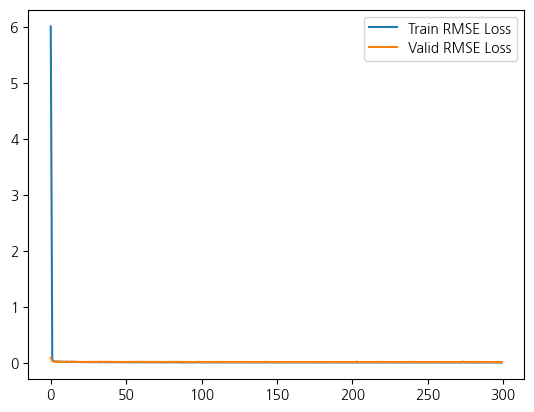

In [293]:
sns.lineplot(train_losses[1:], label='Train RMSE Loss')
sns.lineplot(val_losses[1:], label='Valid RMSE Loss')
plt.legend()
plt.show()

In [294]:
# test
best_epoch = np.argmin(np.array(val_losses)) + 1
print(f'최적의 epoch는 {best_epoch}')
model.load_state_dict(torch.load(os.path.join('./model_data/', '{0:0=2d}.pth'.format(best_epoch))))
model.eval()
output = model(X_test)
        

최적의 epoch는 296


In [297]:
output.shape

torch.Size([1459, 1])

In [298]:
output = torch.exp(output)
output = output.cpu().detach().numpy()

In [299]:
sub = pd.read_csv('./sample_submission.csv')
sub['SalePrice'] = output

In [300]:
sub.to_csv('answer11.csv', index=False)